<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project2/blob/master/model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 2

### Iglezou Myrto - 111520170038

# Model 5


In [2]:
import pandas as pd 
from pandas import DataFrame, read_csv

Download the dataset.

In [3]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv")
df = pd.DataFrame(data=twitterData)
df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


Creating a new dataframe with only two columns, target and text.


In [4]:
df.drop(df.columns.difference(['text','target']), 1, inplace=True)
df['target'].replace({4: 1}, inplace = True)
df.head(5)

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


## Data pre-processing

### Removing the scpecial characters

In [5]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [6]:
df['text'] = df['text'].apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [8]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

df['text'] = df['text'].apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Removing the upercase

In [9]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [10]:
df.head(5)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...


## Word embedding - GloVe
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [11]:
from torchtext.vocab import GloVe
glove = GloVe(name='twitter.27B', dim=25)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:42, 2.16MB/s]                            
100%|█████████▉| 1189007/1193514 [00:27<00:00, 45103.13it/s]

In [12]:
from torchtext.data import Field
text_field = Field(sequential=True,tokenize='spacy',fix_length=100)

label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = df['text'].apply(lambda x: text_field.preprocess(x))
# load fastext simple embedding with 50d
text_field.build_vocab(preprocessed_text, vectors=glove)
# get the vocab instance
vocab = text_field.vocab


100%|█████████▉| 1189007/1193514 [00:40<00:00, 45103.13it/s]

### Create the datasets

We have train, validation and test datasets that contain text and label information. Train has 80%, validation 10% and test 10%.

In [13]:
from torchtext.data import Dataset, Example
fields = (('target', label_field),('text', text_field))
train_dataset, valid_dataset, test_dataset= Dataset(examples=[Example.fromlist(list(r), fields)
                                               for i, r in df.iterrows()],
                                               fields = fields).split(split_ratio = [0.8, 0.1, 0.1])

## Batching sentences together 

In [14]:
from torchtext.data import BucketIterator
train_iter, valid_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, valid_dataset, test_dataset),
                                                          batch_sizes=(64,64,64), sort=False)

## Architecture of NN

In [15]:
import torch
import torch.nn as nn
import numpy as np

In [16]:
class Model_5(nn.Module):
    def __init__(self, input_size, embedding, num_classes = 1, embedding_dim = 25, hidden_size = 100):
        super(Model_5, self).__init__()

        self.embedding = embedding
        self.fc1 = nn.Linear(input_size * embedding_dim, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.embedding[x].reshape(x.size()[0], -1)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [17]:
def train(model,X,y,optimizer,loss_fn):

    # step 1. Zero the gradients
#         model.zero_grad()
        optimizer.zero_grad()
    # step 2. Compute the output
        y_pred = model(X)
    # step 3. Compute the loss
        loss = loss_fn(y_pred.squeeze(), y)
    # step 4. use loss to produce gradients
        loss.backward()
    # step 5. use optimizer to take gradient step
        optimizer.step()
   
        return loss.item()

In [18]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)
  loss = loss_fn(y_pred.squeeze(), y)

  return loss.item()


In [19]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)

In [30]:
def training(net,train_iter,valid_iter,optimizer, loss_function,num_epochs = 5):

  list_of_losses = []
  valid_losses = []

  for epoch in range(num_epochs):
      epoch_losses = []
      net.train()
      for batch in train_iter:
        loss = train(net, batch.text.T, batch.target.float(), optimizer, loss_function)
        epoch_losses.append(loss)

      list_of_losses.append(np.mean(epoch_losses))

      epoch_losses = []
      for batch in valid_iter:
          with torch.no_grad():
              loss = validate(net, batch.text.T, batch.target.float(),loss_function)
              epoch_losses.append(loss)
      
      valid_losses.append(np.mean(epoch_losses))

  return list_of_losses,valid_losses
       

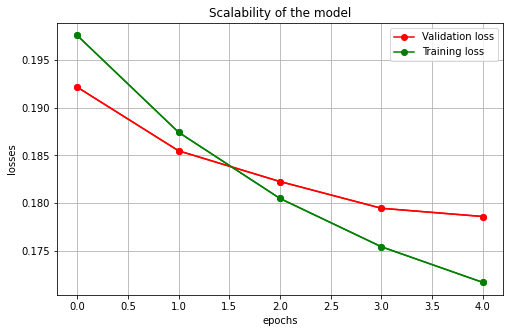

In [27]:
import matplotlib.pyplot as plt

def plot_losses(list_of_losses,valid_losses,tittle):
    plt.figure(figsize=(8,5))

    plt.plot(valid_losses,'o-',color="r")

    plt.plot(list_of_losses,'o-',color="g")

    plt.grid()

    plt.plot(valid_losses, 'o-', color="r",
                    label="Validation loss")
    plt.plot(list_of_losses,  'o-', color="g",
                    label="Training loss")

    plt.legend(loc="best")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.title(title)

    plt.show()

## Training



In [31]:
net = Model_5(100,vocab.vectors)
learning_rate = 0.0001

In [33]:
optimizers = [torch.optim.Adam(net.parameters(), lr=learning_rate),torch.optim.SGD(net.parameters(), lr=learning_rate),
              torch.optim.RMSprop(net.parameters(), lr=learning_rate)]
loss_function = [nn.MSELoss(),nn.BCELoss()]

In [35]:
for op in optimizers:
  for lf in loss_function:
    list_of_losses,valid_losses = training(net,train_iter,valid_iter,op, lf)
    print("Chech for Overfitting-Underfitting")
    tittle=("%s" %op + " ,%s"%lf" )
    plot_losses(list_of_losses,valid_losses,tittle)



KeyboardInterrupt: ignored

## Check for Overfitting-Underfitting

## Testing

In [28]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

accuracy = []
f1 = []
recall = []
precision = []

for batch in test_iter:
      
    y_pred = predict(net,batch.text.T)
    y_pred = y_pred.detach().numpy()
    y_test = batch.target.float()
    y_test = y_test.numpy()

    acc = accuracy_score(y_test, y_pred)
    f1_sc = f1_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    
    accuracy.append(acc)
    f1.append(f1_sc)
    recall.append(rec)
    precision.append(prec)
    

## Scores

In [29]:
print("Accuracy: ",np.mean(accuracy))
print("F1-score: ",np.mean(f1))
print("Recall-score: ",np.mean(recall))
print("Precision: ",np.mean(precision))

Accuracy:  0.733078125
F1-score:  0.7298919228823281
Recall-score:  0.7329499408711433
Precision:  0.7331187452518079
